In [49]:
!pip install pot

     |████████████████████████████████| 198 kB 862 kB/s eta 0:00:01


In [39]:
#import os
#from pathlib import Path

from PIL import Image
import numpy as np
#from matplotlib import pyplot as plt
#import ot
#import imageio
from copy import copy
#import cvxpy as cp


rng = np.random.RandomState(42)

In [46]:
import cv2
image_ent = cv2.imread("entropic_uot.png");
gray = cv2.cvtColor(image_ent, cv2.COLOR_BGR2GRAY)
cv2.imshow('Original image',image_ent)
cv2.imshow('Gray image', gray)

In [47]:
np.shape(image_ent)

(231, 231, 3)

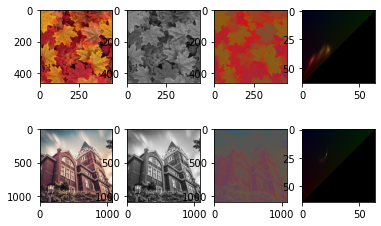

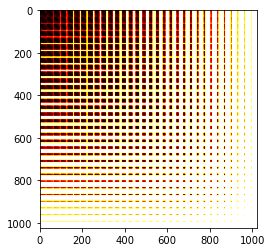

0 0.09557042570253897 0.03412117219949342 1.0
10 0.23635948328018316 0.05548351647586234 1.0
20 0.2627210585969083 0.05840358334741186 1.0
30 0.28435631081412543 0.061697648985838245 1.0
40 0.30279022656357246 0.0649631859454619 1.0
50 0.31878833565558207 0.06813368289034467 1.0
60 0.33281752310736434 0.0711702015970925 1.0
70 0.3452231350717036 0.0740528665493319 1.0
80 0.3562723858234489 0.07677239813443838 1.0
90 0.36618086832605407 0.07931597952867013 1.0
100 0.3751339483172236 0.08165330802041625 1.0
110 0.3832864765006265 0.08379019624094439 1.0
120 0.3907575561981116 0.085745885689998 1.0
130 0.39764512353068615 0.0875250820940294 1.0
140 0.4040311010753006 0.08914114008066856 1.0
150 0.4099852681972246 0.09060388306798552 1.0
160 0.41556306829358186 0.09193529987988786 1.0
170 0.4208082742415902 0.0931522458560849 1.0
180 0.4257570017053366 0.09426502959332946 1.0
190 0.4304422099944374 0.09527654609355034 1.0
200 0.43489323748508146 0.09618680751846896 1.0
210 0.43913772151502

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


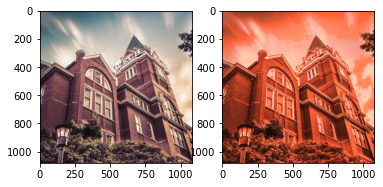

In [48]:
from sot import *;
import numpy as np
import matplotlib.pyplot as plt

def rgb2luv(I):
    J = np.zeros(I.shape);
    J[:,:,0] = np.sum(I,axis=2);
    J[:,:,1] = I[:,:,0]/(1e-14+J[:,:,0]);
    J[:,:,2] = I[:,:,1]/(1e-14+J[:,:,0]);
    return J;

def luv2rgb(J):
    I = np.zeros(J.shape);
    I[:,:,0] = (J[:,:,0]+1e-14)*J[:,:,1];
    I[:,:,1] = (J[:,:,0]+1e-14)*J[:,:,2];
    I[:,:,2] = (J[:,:,0]+1e-14)*(1.0-J[:,:,1]-J[:,:,2]);
    return I;

def make_2d_histogram(X,B):
    H = np.zeros((B,B));
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
           r = X[i,j,1];
           g = X[i,j,2];
           
           k = int(np.clip(B*r,0,B-1));
           l = int(np.clip(B*g,0,B-1));

           H[k,l] += 1.0;
    
    H /= X.shape[0]*X.shape[1];
    return H;

def make_3d_histogram(X,B):
    H = np.zeros((B,B,B));
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            r = int(np.clip(B*X[i,j,0],0,B-1));
            g = int(np.clip(B*X[i,j,1],0,B-1));
            b = int(np.clip(B*X[i,j,2],0,B-1));
            H[r,g,b] += 1.0;
    H /= X.shape[0]*X.shape[1];
    return H;

#X = img.imread("blossom.jpg")/255.0;
#Y = img.imread("forest.jpg")/255.0;


Y = img.imread("gatech.jpeg")/255.0;
X = img.imread("fall leaves.jpg")/255.0;
Z = img.imread("entropic_uot.png")/255.0;

luvX = rgb2luv(X);
luvY = rgb2luv(Y);

chrX = X/(1e-14+np.repeat(luvX[:,:,0].reshape((X.shape[0],X.shape[1],1)),3,axis=2));
chrY = Y/(1e-14+np.repeat(luvY[:,:,0].reshape((Y.shape[0],Y.shape[1],1)),3,axis=2));

B = 64;

L = np.linspace(0.0,1.0,B);
C = np.zeros((B,B,3));

for k in range(B):
    for l in range(B-k):
        r = L[k];
        g = L[l];
        b = 1.0-r-g;
        C[k,l,0] = r;
        C[k,l,1] = g;
        C[k,l,2] = b;
            
mu = make_2d_histogram(luvX,B);
nu = make_2d_histogram(luvY,B);

smu = mu/np.max(mu);
snu = nu/np.max(nu);

Cmu = C*(0.125+0.875*np.repeat(smu.reshape((B,B,1)),3,axis=2));
Cnu = C*(0.125+0.875*np.repeat(snu.reshape((B,B,1)),3,axis=2));


f, ax = plt.subplots(2,4);
ax[0,0].imshow(X);
ax[0,1].imshow(luvX[:,:,0],cmap='gray');
ax[0,2].imshow(chrX);
ax[0,3].imshow(Cmu,cmap='gray');

ax[1,0].imshow(Y);
ax[1,1].imshow(luvY[:,:,0],cmap='gray');
ax[1,2].imshow(chrY);
ax[1,3].imshow(Cnu,cmap='gray');

plt.show();

B = 32;

D = 4*(B-1.0)**2*np.ones((B*B,B*B)); # what is this?
for i in range(B):
    for j in range(B-i):        
        for k in range(B):
            for l in range(B-k):
                D[B*i+j,B*k+l] = (i-k)**2+(j-l)**2;
D /= (B-1.0)**2;
plt.imshow(D,cmap='hot');
plt.show();

mu = make_2d_histogram(luvX,B);
nu = make_2d_histogram(luvY,B);

T = opt_ot(nu.reshape((-1,)),mu.reshape((-1,)),D,L=1000,igam=1e-3);
T_ent = 0;
#T += 1e-14;
#T /= np.sum(T);

om = np.zeros((B,B,3));
for i in range(B):
    for j in range(B-i):
        som = 1e-14;
        for k in range(B):
            for l in range(B-k):
                om[i,j,0] += k*T[B*i+j,B*k+l];
                om[i,j,1] += l*T[B*i+j,B*k+l];
                om[i,j,2] += (B-1-k-l)*T[B*i+j,B*k+l];
                som += T[B*i+j,B*k+l];
        om[i,j,0] /= som;
        om[i,j,1] /= som;
        om[i,j,2] /= som;

cY = np.zeros(Y.shape);
nY = np.zeros(Y.shape);
for i in range(Y.shape[0]):
    for j in range(Y.shape[1]):
        r = luvY[i,j,1];
        g = luvY[i,j,2];
        b = 1-r-g;
        
        k = int(np.clip(B*r,0.0,B-1.0));
        l = int(np.clip(B*g,0.0,B-1.0));
        
        cY[i,j,:] = (luvY[i,j,0]+1e-14)*np.array([r,g,b]);
        nY[i,j,:] = (luvY[i,j,0]+1e-14)*om[k,l,:]/(B-1.0);

f, ax = plt.subplots(1,2);
ax[0].imshow(cY);
ax[1].imshow(nY);
plt.show();

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


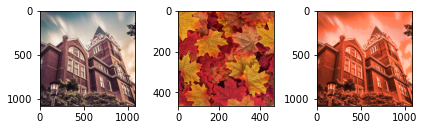

In [23]:
f, ax = plt.subplots(1,3);
ax[0].imshow(cY);
ax[1].imshow(X);
ax[2].imshow(nY);
f.tight_layout();

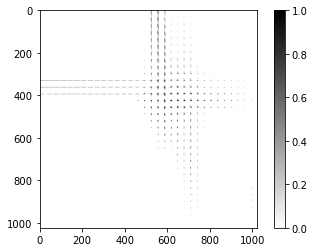

In [90]:
plt.imshow(T > 0.01, cmap = 'binary');
plt.colorbar();


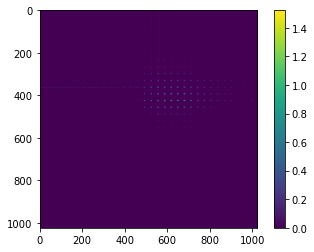

In [25]:
plt.imshow(T);
plt.colorbar();


In [26]:
sum(sum(T > 0.01))/(np.shape(T)[0]*np.shape(T)[1])

0.0061511993408203125

In [27]:
np.shape(T)

(1024, 1024)

In [28]:
len(T)

1024

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


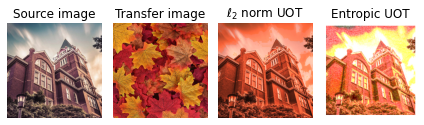

In [87]:
f, ax = plt.subplots(1,4);
ax[0].imshow(cY);
ax[0].axis('off')
ax[0].title.set_text('Source image')

ax[1].imshow(X);
ax[1].axis('off')
ax[1].title.set_text('Transfer image')

ax[2].imshow(nY);
ax[2].axis('off')
ax[2].title.set_text('$\ell_2$ norm UOT')

ax[3].imshow(image_ent);
ax[3].axis('off')
ax[3].title.set_text('Entropic UOT')

f.tight_layout();



In [35]:
np.shape(X)

(466, 466, 3)

In [36]:
np.shape(nY)

(1080, 1080, 3)

In [37]:
np.shape(cY)

(1080, 1080, 3)

In [40]:
image_ent = Image.open(Z)
image_ent.load()


AttributeError: 'numpy.ndarray' object has no attribute 'read'

In [ ]:
def cmyk_to_rgb(c, m, y, k, cmyk_scale, rgb_scale=255):
    r = rgb_scale * (1.0 - c / float(cmyk_scale)) * (1.0 - k / float(cmyk_scale))
    g = rgb_scale * (1.0 - m / float(cmyk_scale)) * (1.0 - k / float(cmyk_scale))
    b = rgb_scale * (1.0 - y / float(cmyk_scale)) * (1.0 - k / float(cmyk_scale))
    return r, g, b

In [56]:
from PIL import Image
image_ent = Image.open('entropic_uot.png')
if image_ent.mode == 'CMYK':
    image_ent = image_ent.convert('RGB')

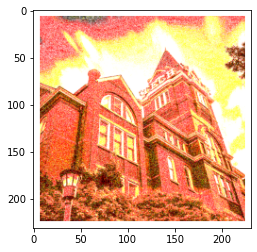

In [57]:
plt.imshow(image)